# Fractopo â€“ Fracture Network Analysis

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Cell contents only required for development env runs
from importlib.util import find_spec

if find_spec("fractopo") is None:
    import sys

    sys.path.append("..")

In [3]:
from pathlib import Path
from shutil import rmtree
from fractopo.analysis.network import Network
import fractopo.contour_grid as contour_grid
import matplotlib.pyplot as plt
import geopandas as gpd

plt.close()

## Data

Trace and target area data required. The paths can be urls to GeoJSON or local file paths to spatial filetypes (e.g. shapefile, geopackage). The name is used in plot labels and titles. 

1. Pass paths to your **validated** trace and area data here and name the analysis. E.g.,

    * The path is relative to the notebook directory. To make things easy you should've copied the notebook the working directory which       either directly contains your trace and area data or has the folder that does.

``` {python}
trace_data = "traces.gpkg"
area_data = "target_area.gpkg"
name = "my-analysis-name"
```

   * Note that the analysis name is used to create a folder like such `results/my-analysis-name` where all analysis results are saved to. If such a folder exists, all contents        will be overridden in the `my-analysis-name` folder.

In [4]:
trace_data = ""
area_data = ""
name = ""

The defaults in the next cell are only applied if no parameters are given to the above cell. This will result in a **default** analysis of a trace and area data downloaded from the urls.

In [5]:
if len(trace_data) == 0:
    # Set defaults
    # Trace and target area data available on GitHub
    trace_data = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_traces.geojson"
    area_data = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_area.geojson"
    # Name the dataset
    name = "KB11"

2. The default analysis set can now be run! To run the notebook, click on the double-right-arrow on at the top of the notebook below the tab bar.

   * You can see the cells being executed with numbers appearing on the left.
   * Some cells will take much longer than others depending on code execution time.
   * Scroll down the notebook as the numbers appear until all cells have been reached.
   * If the analysis throws errors they will appear in big red boxes.

3. If no errors occur during running the results of the analysis will be in `results/my-analysis-name` folder.

   * The folder will contain plots and spatial data files:
   
       * Rose plot of trace azimuths, length-weighted
       * Length distribution plots
       * XYI-plots
       * Branches and nodes
       * Contour grids
       * Etc.

4. Some analyses will be run with default settings which might not fit your dataset.

    * This is especially the case for contour grids.
    * Scroll down to the contour grid section to configure if the results are not to your liking.

In [6]:
# Make/overwrite results dir
results_dir = Path("results") / name
if results_dir.exists():
    rmtree(results_dir)
results_dir.mkdir(parents=True)

In [7]:
# Use geopandas to load data from urls/paths
traces = gpd.read_file(trace_data)
area = gpd.read_file(area_data)

In [8]:
area.total_bounds

array([ 465993.9355, 6691562.9084,  466048.6197, 6691606.3108])

In [9]:
def focus_plot_to_bounds(ax, total_bounds):
    """ Focus plot to given bounds. """
    xmin, ymin, xmax, ymax = total_bounds
    extend_x = (xmax - xmin) * 0.05
    extend_y = (ymax - ymin) * 0.05
    ax.set_xlim(xmin - extend_x, xmax + extend_x)
    ax.set_ylim(ymin - extend_y, ymax + extend_y)
    return ax

def save_fig(fig, results_dir: Path, name:str):
    """ Save figure as svg image to results dir. """
    fig.savefig(results_dir / f"{name}.svg", bbox_inches="tight")
    
def as_gpkg_and_shp(geodataframe, name):
    geodataframe.to_file(results_dir / f"{name}.gpkg", driver="GPKG")
    shp_dir = (results_dir / f"{name}_as_shp")
    shp_dir.mkdir()
    geodataframe.to_file(shp_dir / f"{name}.shp")

## Visualizing trace map data

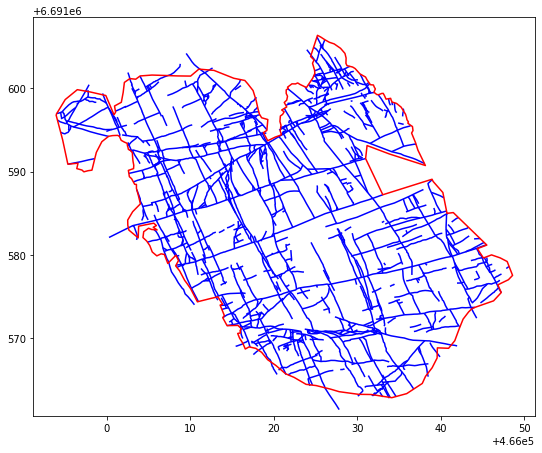

In [10]:
fig, ax = plt.subplots(figsize=(9, 9))
traces.plot(ax=ax, color="blue")
area.boundary.plot(ax=ax, color="red")
ax = focus_plot_to_bounds(ax, area.total_bounds)
save_fig(fig, results_dir, "base_visualization")

## Create Network

In [11]:
# Create Network and automatically determine branches and nodes
network = Network(
    traces, area, name=name, determine_branches_nodes=True, snap_threshold=0.001
)
as_gpkg_and_shp(network.branch_gdf, "branches")
as_gpkg_and_shp(network.node_gdf, "nodes")

## Visualizing branches and nodes

In [12]:
from fractopo.general import CC_branch, CI_branch, II_branch, X_node, Y_node, I_node


# Function to determine color for each branch and node type
def assign_colors(feature_type: str):
    if feature_type in (CC_branch, X_node):
        return "green"
    if feature_type in (CI_branch, Y_node):
        return "blue"
    if feature_type in (II_branch, I_node):
        return "black"
    return "red"

| Branch or Node Type | Color |
|---------------------|-------|
| C - C, X            | Green |
| C - I, Y            | Blue  |
| I - I, I            | Black |
| Other               | Red   |

### Branches

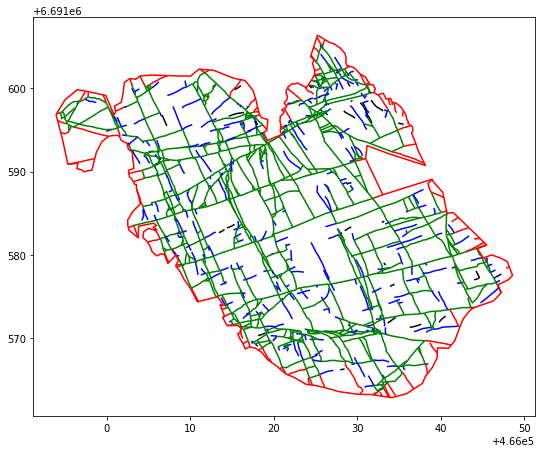

In [13]:
fig, ax = plt.subplots(figsize=(9, 9))
network.branch_gdf.plot(
    colors=[assign_colors(bt) for bt in network.branch_types], ax=ax
)
area.boundary.plot(ax=ax, color="red")
save_fig(fig, results_dir, "branches_visualization")

### Nodes

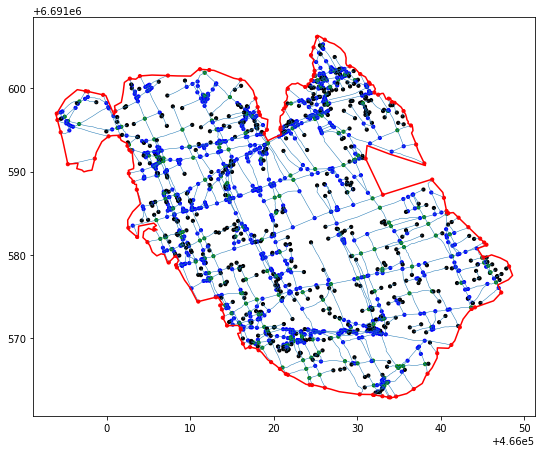

In [14]:
fig, ax = plt.subplots(figsize=(9, 9))
# Traces
network.trace_gdf.plot(ax=ax, linewidth=0.5)
# Nodes
network.node_gdf.plot(
    c=[assign_colors(bt) for bt in network.node_types], ax=ax, markersize=10
)
area.boundary.plot(ax=ax, color="red")
ax = focus_plot_to_bounds(ax, area.total_bounds)
save_fig(fig, results_dir, "nodes_visualization")

## Rose plots

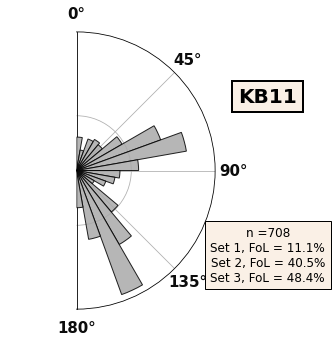

In [15]:
# Plot azimuth rose plot of fracture traces
azimuth_bin_dict, fig, ax = network.plot_trace_azimuth()
save_fig(fig, results_dir, "trace_length_weighted_rose_plot")

## Length distributions

### Trace length distribution

In [16]:
# Fit for traces
fit_traces = network.trace_lengths_powerlaw_fit()

Calculating best minimal value for power law fit


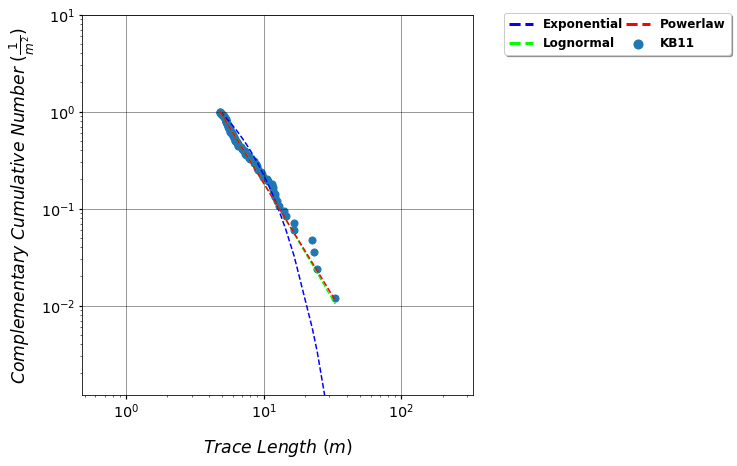

In [17]:
# Plot length distribution fits (powerlaw, exponential and lognormal) of fracture traces
fit, fig, ax = network.plot_trace_lengths()
save_fig(fig, results_dir, "trace_length_distribution_fits")

In [18]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit_traces.xmin}")
print(f"Powerlaw exponent: {fit_traces.alpha - 1}")
print(
    f"Proportion of data cut off by cut off: {network.trace_lengths_cut_off_proportion()}"
)
print(
    f"Compare powerlaw fit to lognormal: R, p = {fit_traces.distribution_compare('power_law', 'lognormal')}"
)

Automatically determined powerlaw cut-off: 4.815579557192599
Powerlaw exponent: 2.323399316187791
Proportion of data cut off by cut off: 0.8813559322033898
Compare powerlaw fit to lognormal: R, p = (-0.009629061290125973, 0.9205510020886896)


### Branch length distribution

In [19]:
# Fit for branches
fit_branches = network.branch_lengths_powerlaw_fit()

Calculating best minimal value for power law fit


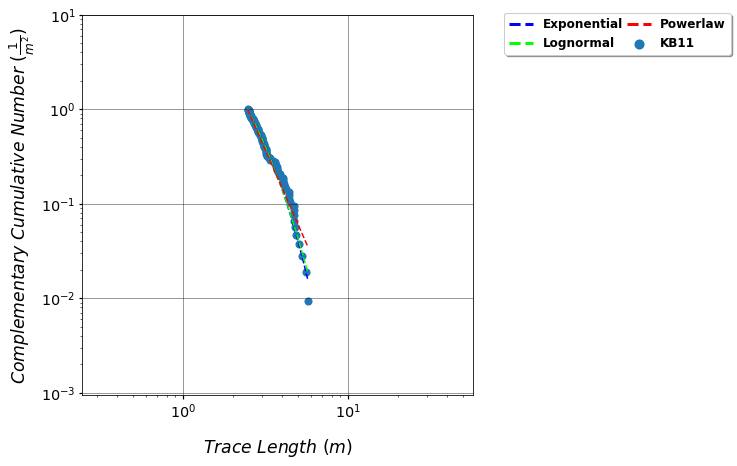

In [20]:
# Plot length distribution fits (powerlaw, exponential and lognormal) of fracture branches
fit, fig, ax = network.plot_branch_lengths()
save_fig(fig, results_dir, "branch_length_distribution_fits")

In [21]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit_branches.xmin}")
print(f"Powerlaw exponent: {fit_branches.alpha - 1}")
print(
    f"Proportion of data cut off by cut off: {network.branch_lengths_cut_off_proportion()}"
)
print(
    f"Compare powerlaw fit to lognormal: R, p = {fit_branches.distribution_compare('power_law', 'lognormal')}"
)

Automatically determined powerlaw cut-off: 2.4602426465576075
Powerlaw exponent: 3.9790958453575085
Proportion of data cut off by cut off: 0.9488416988416989
Compare powerlaw fit to lognormal: R, p = (-1.564679589933731, 0.21188128250465044)


## Crosscutting and abutting relationships

In [22]:
# Sets are defaults
print(f"Azimuth set names: {network.azimuth_set_names}")
print(f"Azimuth set ranges: {network.azimuth_set_ranges}")

Azimuth set names: ('1', '2', '3')
Azimuth set ranges: ((0, 60), (60, 120), (120, 180))


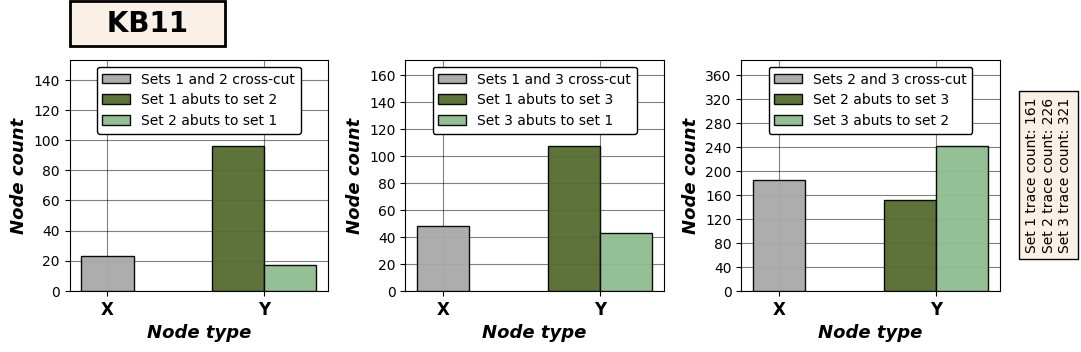

In [23]:
# Plot crosscutting and abutting relationships between azimuth sets
figs, fig_axes = network.plot_azimuth_crosscut_abutting_relationships()
for i, fig in enumerate(figs):
    save_fig(fig, results_dir, f"azimuth_set_relationships_{i}")

## Node and branch proportions

In [24]:
network.node_counts

{'X': 270, 'Y': 824, 'I': 478, 'E': 114}

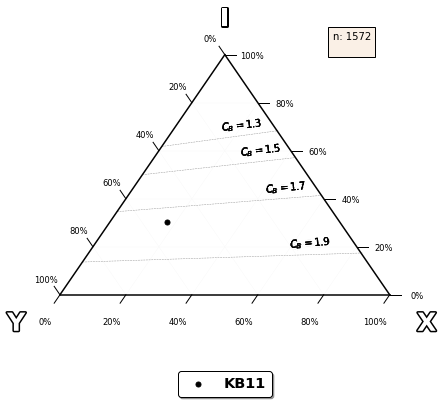

In [25]:
# Plot ternary XYI-node proportion plot
fig, ax, tax = network.plot_xyi()
save_fig(fig, results_dir, "xyi_ternary_plot")

In [26]:
network.branch_counts

{'C - C': 1521,
 'C - I': 410,
 'I - I': 28,
 'C - E': 100,
 'I - E': 12,
 'E - E': 1}

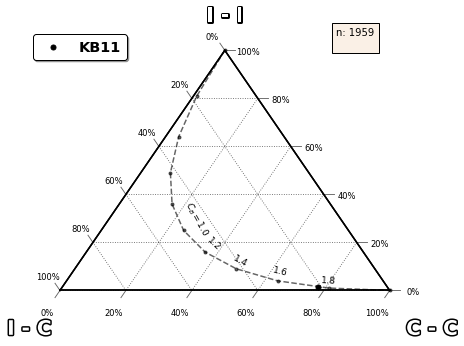

In [27]:
# Plot ternary branch (C-C, C-I, I-I) proportion plot
fig, ax, tax = network.plot_branch()
save_fig(fig, results_dir, "branch_ternary_plot")

# General topological and geometric parameters

In [28]:
network.parameters
gpd.GeoSeries({**network.parameters})

Number of Traces                 651.000000
Number of Branches              2015.000000
Fracture Intensity B21             1.263373
Fracture Intensity P21             1.263373
Areal Frequency P20                0.525890
Areal Frequency B20                1.627756
Trace Mean Length                  2.208940
Branch Mean Length                 0.776144
Dimensionless Intensity P22        2.790715
Dimensionless Intensity B22        0.980559
Connections per Trace              3.360983
Connections per Branch             1.762779
Fracture Intensity (Mauldon)       1.435744
Fracture Density (Mauldon)         0.525890
Trace Mean Length (Mauldon)        2.730119
Connection Frequency               0.883754
dtype: float64

In [29]:
def get_crs(traces, area):
    for crs_maybe in (traces.crs, area.crs):
        if crs_maybe is not None:
            return crs_maybe
    return None
        
params_point = gpd.GeoDataFrame([{**network.parameters, "geometry":area.geometry.values[0].representative_point()}])
crs_maybe = get_crs(traces, area)
if crs_maybe is not None:
    params_point.set_crs(crs_maybe)
as_gpkg_and_shp(params_point, "params")


# Contour grids for target area

Configuration of contour grids happens here.

* `cell_width` is the width of the sample cell in the grid. Change the number from 1.0 (meters in ETRS-TM35FIN) to your liking
* `snap_threshold` is the snapping threshold for your dataset. See the `tracevalidate` guide for more info (for ETRS-TM35FIN crs and with drone orthophotography data, values between 0.01 and 0.001 are fine. Results may vary).

In [30]:
sampled_grid = contour_grid.run_grid_sampling(
    traces=network.trace_gdf,
    branches=network.branch_gdf,
    nodes=network.node_gdf,
    cell_width=1.0,
    snap_threshold=0.01,
)
if crs_maybe is not None:
    sampled_grid.set_crs(crs_maybe)
as_gpkg_and_shp(sampled_grid, "contour_grid")

In [31]:
sampled_grid.columns

Index(['geometry', 'Number of Traces', 'Number of Branches',
       'Trace Mean Length', 'Branch Mean Length', 'Connections per Branch',
       'Areal Frequency B20', 'Fracture Intensity B21',
       'Dimensionless Intensity B22', 'Connections per Trace',
       'Areal Frequency P20', 'Fracture Intensity P21',
       'Dimensionless Intensity P22', 'Trace Mean Length (Mauldon)',
       'Fracture Intensity (Mauldon)', 'Fracture Density (Mauldon)',
       'Connection Frequency'],
      dtype='object')

In [32]:
# From https://geopandas.org/mapping.html
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_contour(column: str):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sampled_grid.plot(
        column=column, legend=True, cax=cax, ax=ax, legend_kwds={"label": column}
    )
    return fig, ax

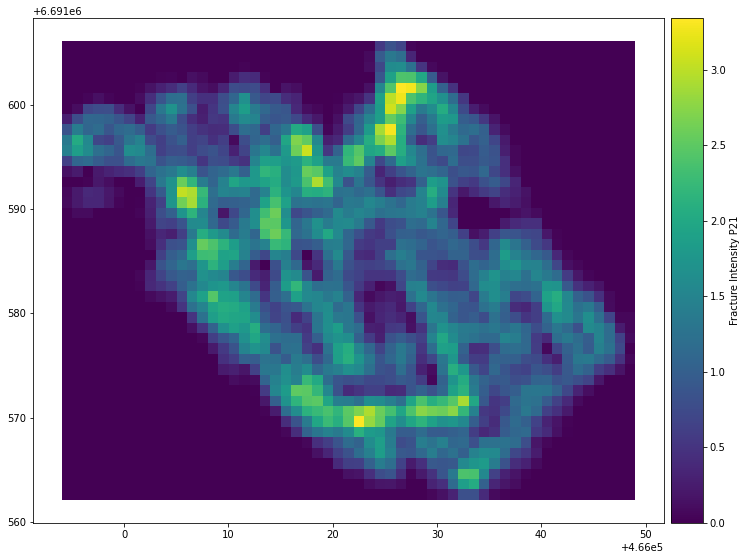

In [33]:
fig, ax = plot_contour("Fracture Intensity P21")
save_fig(fig, results_dir, "P21_contour")

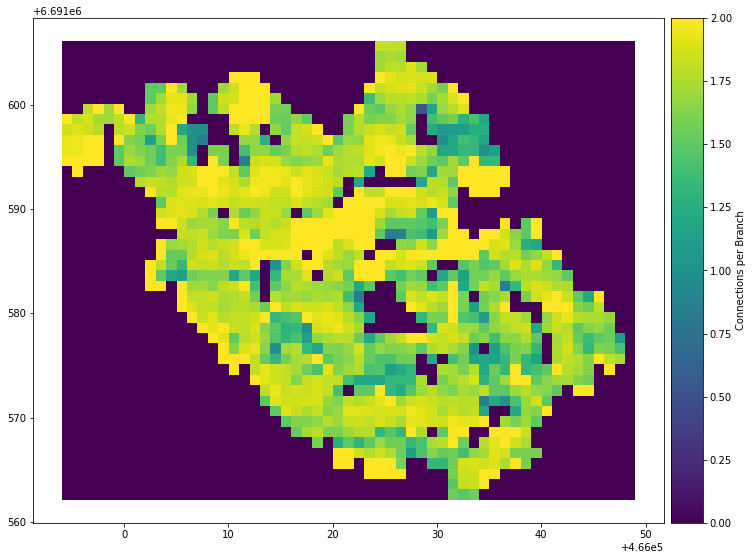

In [34]:
fig, ax = plot_contour("Connections per Branch")
save_fig(fig, results_dir, "Connections_per_branch_contour")